In [24]:
import sys
import os
sys.path.append(os.path.abspath("..")) 

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import scipy.signal as signal

from pySNA import *

baseline = 256e-12 #加/减去offset之后的baseline
var = 2e-12
offset= 5e-12
threshold = baseline*0.5
pySNA = PySNA(baseline=baseline, var=var, threshold=threshold)

In [25]:
file_path = "(K_buffer_D91N_180mV_40T)20250704154031.dat"

# 加载数据
pySNA.load(file_path, output_samplerate=10000.)#, lp_filter_cutoff=2500.

2026-02-17 03:02:55,707 - INFO - Successfully loaded .dat file: (K_buffer_D91N_180mV_40T)20250704154031.dat
2026-02-17 03:02:55,709 - WARNING - Already LP filtered lower than or at entry, data will not be filtered.
2026-02-17 03:02:55,819 - INFO - Baseline = 41.45 pA, RMS = 107.33 pA


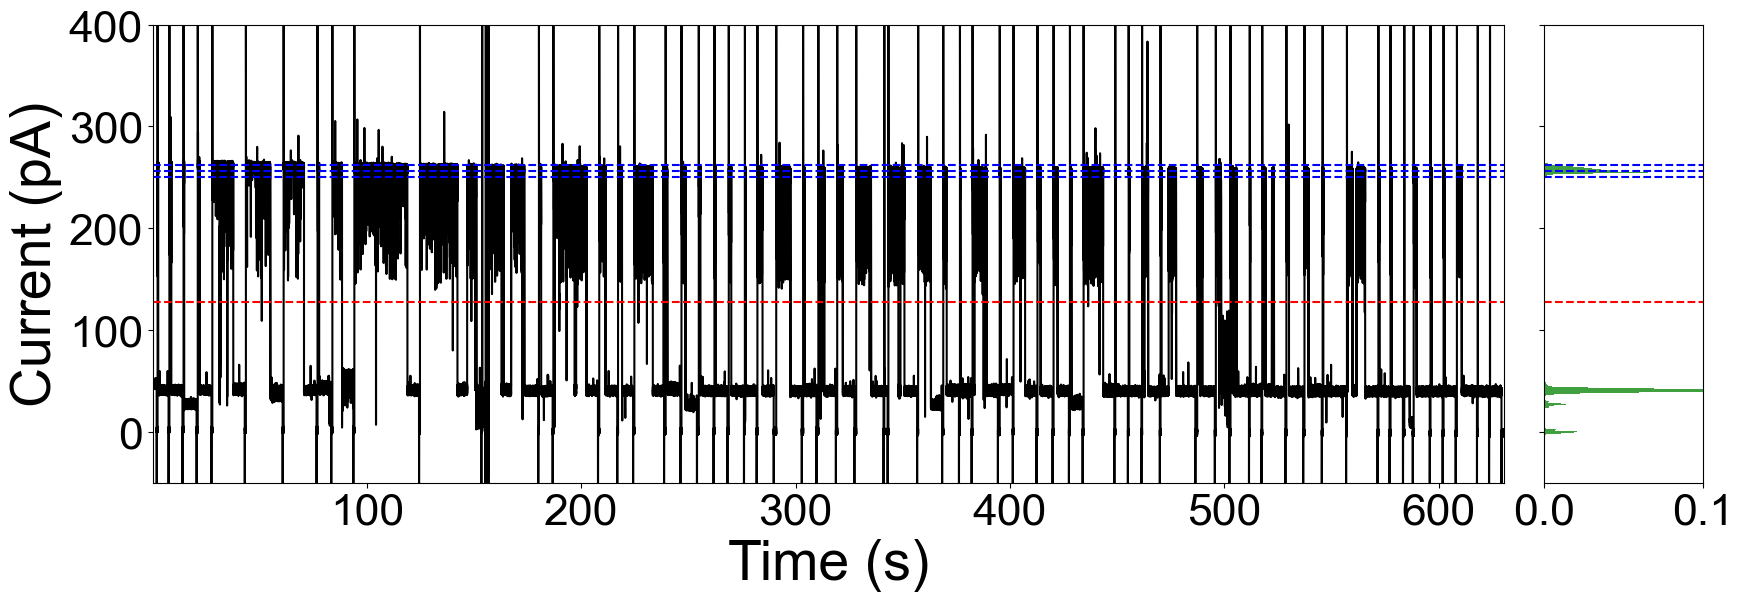

In [10]:
pySNA.plot_temporal_and_hist(analyzed=False,ylim=[-50,400],color='g',hist_scale=0.1)

In [11]:
# Step 1: Find all points below the threshold
below = np.where((pySNA.data < pySNA.threshold) & (pySNA.data > 1e-12))[0]

# Step 2: Locate event start and end points
startandend = np.diff(below)
startpoints = np.insert(startandend, 0, 2)
endpoints = np.insert(startandend, -1, 2)

startpoints = np.where(startpoints > 1)[0]
endpoints = np.where(endpoints > 1)[0]

startpoints = below[startpoints]
endpoints = below[endpoints]

temp = endpoints-startpoints
startpoints = startpoints[temp > 2e3]
endpoints = endpoints[temp > 2e3]


endpoints = endpoints[ pySNA.data[startpoints-10] > pySNA.threshold ]
startpoints = startpoints[ pySNA.data[startpoints-10] > pySNA.threshold ]

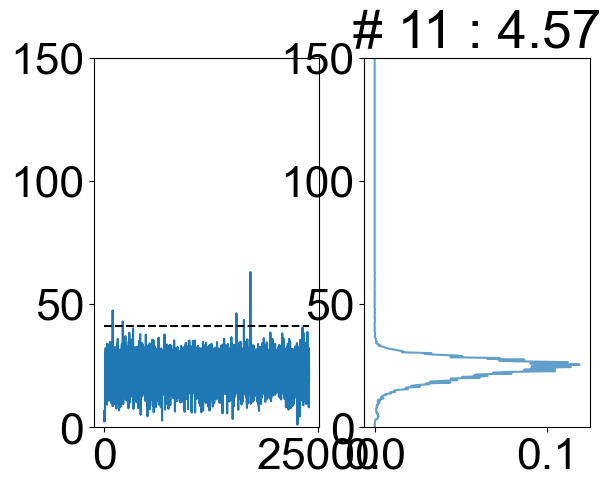

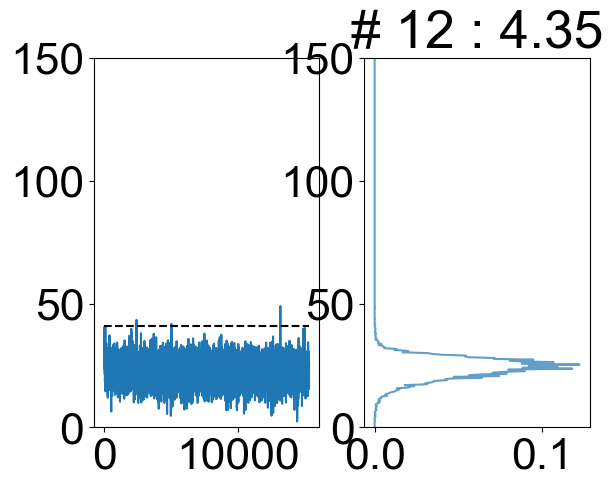

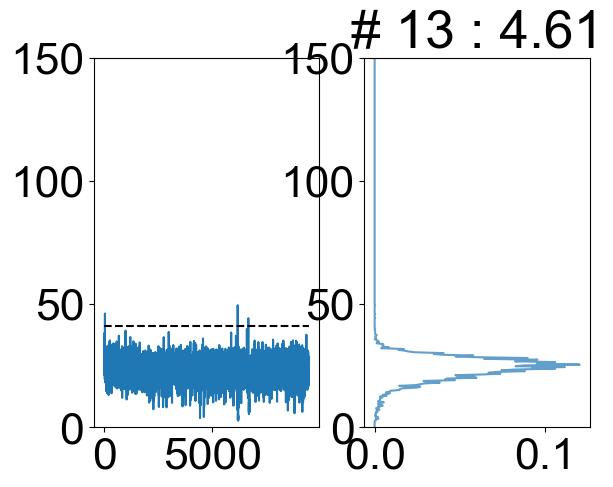

75


In [12]:
from scipy.optimize import curve_fit

# 定义高斯函数用于拟合
def gaussian(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))
    
peak_position = []
peak_width = []
segment_median = []
segment_mean = []
segment_std = []
segment_dwell = []

for j in range(len(startpoints)):
    segment = pySNA.data[startpoints[j]+50:endpoints[j]-50]*1e12
    segment_median.append(np.median(segment)/pySNA.baseline/1e12)
    segment_std.append(np.std(segment))
    
    #if np.std(segment) > 10 :
    if np.median(segment)/pySNA.baseline/1e12 < 0.1 :
        plt.subplot(1,2,1)
        plt.plot(segment)
        plt.hlines(y=41,xmin=0,xmax=len(segment),colors='k',linestyles='--') #TTTT
        plt.ylim([0,150])    
        # 绘制包络线
        plt.subplot(1,2,2)
        hist, bins = np.histogram(segment, bins=451, density=True, range=(0, 150))
        bin_centers = (bins[:-1] + bins[1:]) / 2  # 计算每个 bin 的中心位置
        plt.plot(hist, bin_centers, alpha=0.7)
        plt.ylim([0,150])
        plt.title(f"# {j} : {np.std(segment):.2f}")
        plt.show()
        
startpoints = startpoints[(np.array(segment_median) > 0.05) & (np.array(segment_median) < 0.45) & (np.array(segment_std) < 50)]
endpoints = endpoints[(np.array(segment_median) > 0.05) & (np.array(segment_median) < 0.45) & (np.array(segment_std) < 50)]

pySNA.startpoints = startpoints
pySNA.endpoints = endpoints
print(len(startpoints))

peak_position = []
peak_width = []
segment_median = []
segment_mean = []
segment_std = []
segment_dwell = []
temp = []

for j in range(len(startpoints)):
    #print(j)
    segment = pySNA.data[startpoints[j]+50:endpoints[j]-50]*1e12
    segment_dwell.append(((endpoints[j]-50) - (startpoints[j]+50))/1e4)
    segment_median.append(np.median(segment)/pySNA.baseline/1e12)
    temp.append(np.median(segment))
    segment_mean.append(np.mean(segment)/pySNA.baseline/1e12)
    segment_std.append(np.std(segment))
    
    # 拟合高斯函数
    try:
        hist, bins = np.histogram(segment, bins=451, density=True, range=(0, 150))
        bin_centers = (bins[:-1] + bins[1:]) / 2  # 计算每个 bin 的中心位置
        popt, _ = curve_fit(gaussian, bin_centers, hist, p0=[max(hist), bin_centers[np.argmax(hist)], 10])
        peak_position.append(popt[1])
        peak_width.append(popt[2] * 2.355)  # 半峰宽 = 2.355 * sigma
    except RuntimeError:
        print(f"Segment {j}: Gaussian fitting failed.")
        continue

(-50.0, 150.0)

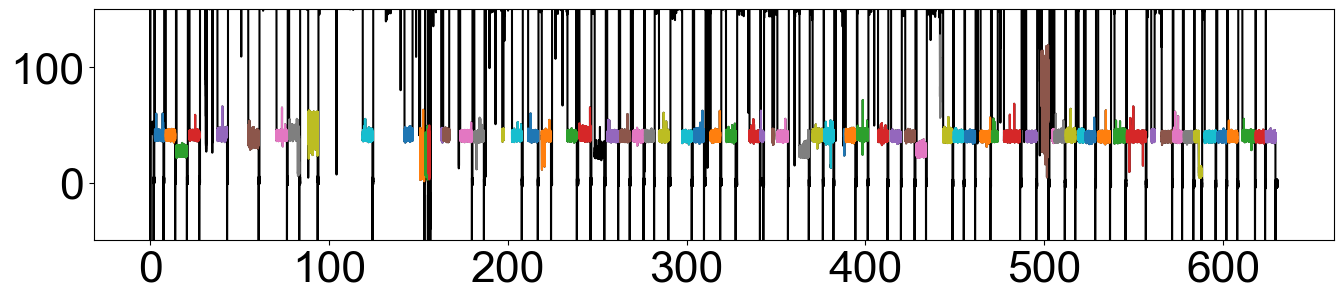

In [13]:
# 绘制直方图分布
plt.figure(figsize=(16, 3))

plt.plot(pySNA.t, pySNA.data*1e12, 'k')
for j in range(len(startpoints)):
    plt.plot(pySNA.t[startpoints[j]+50:endpoints[j]-50], pySNA.data[startpoints[j]+50:endpoints[j]-50]*1e12)

plt.ylim(-50,150)

(0.0, 10.0)

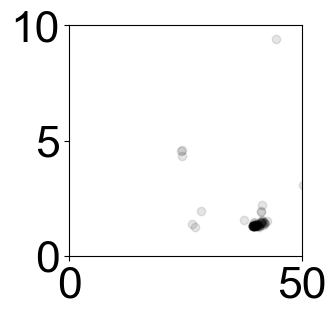

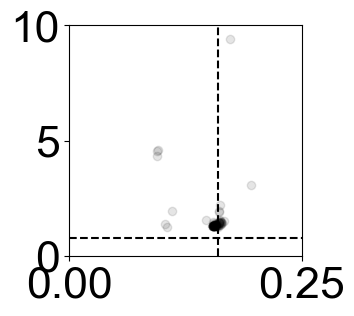

In [14]:
plt.figure(figsize=(3, 3))
plt.scatter(temp,segment_std,color='#000000',alpha=0.1)
plt.xlim(0,50)
plt.ylim(0,10)
plt.savefig('T40K_scatter.svg',format='svg',dpi=300)

plt.figure(figsize=(3, 3))
plt.scatter(segment_median,segment_std,color='#000000',alpha=0.1)
plt.plot([0.1600,0.1600],[0,10],'k--')
plt.plot([0,0.25],[0.8,0.8],'k--')
plt.xlim(0,0.25)
plt.ylim(0,10)

(array([0., 0., 0., ..., 0., 0., 0.], shape=(151,)),
 array([  0.    ,   0.9934,   1.9868, ..., 148.0132, 149.0066, 150.    ],
       shape=(152,)),
 <BarContainer object of 151 artists>)

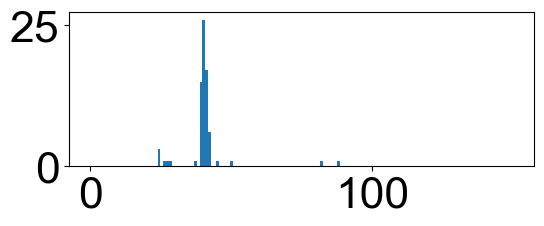

In [15]:
plt.figure(figsize=(6, 2))
plt.hist(peak_position, bins=151, density=False, range=(0, 150))

(array([0., 0., 0., ..., 0., 0., 0.], shape=(76,)),
 array([0.    , 0.0066, 0.0132, ..., 0.4868, 0.4934, 0.5   ], shape=(77,)),
 <BarContainer object of 76 artists>)

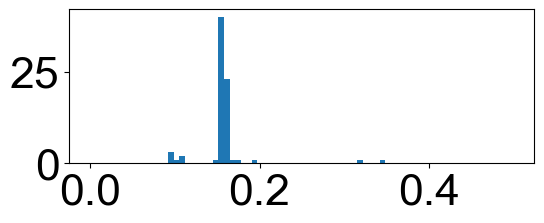

In [16]:
normalized_peak_position = [x / pySNA.baseline / 1e12 for x in peak_position]
plt.figure(figsize=(6, 2))
plt.hist(normalized_peak_position, bins=76, density=False, range=(0, 0.5))

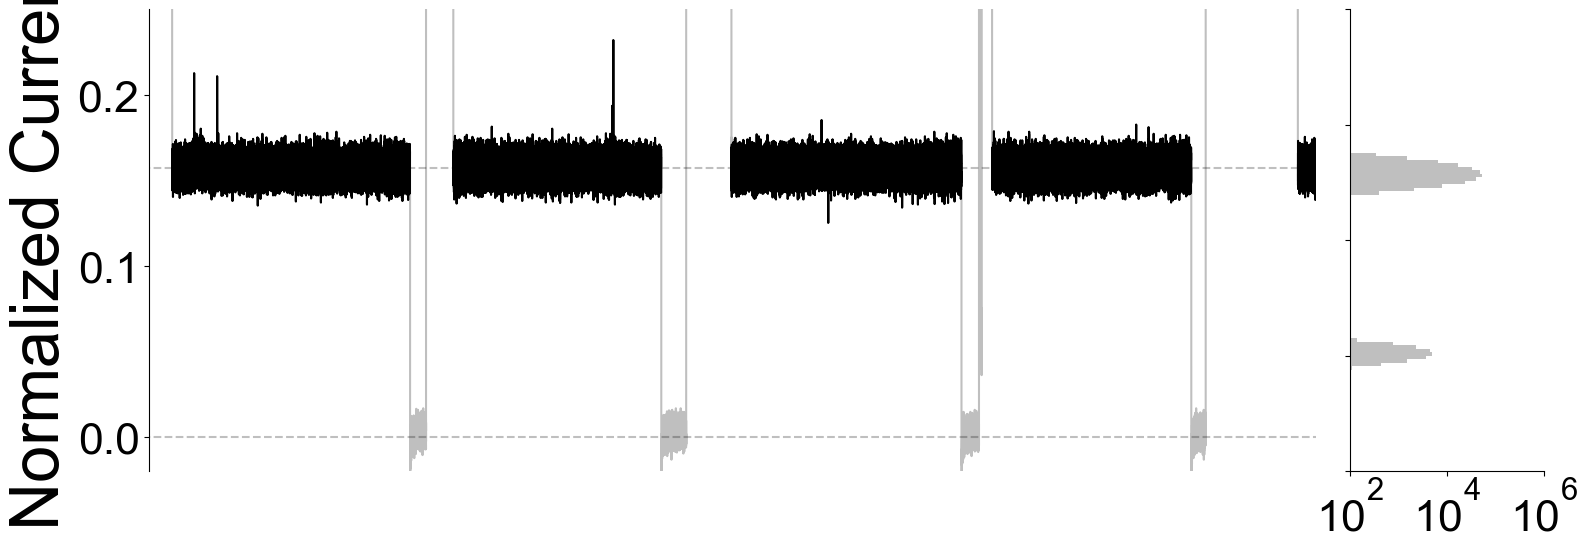

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# --------------------- 假设你已有变量 ---------------------
# pySNA.t, pySNA.data, pySNA.baseline, pySNA.startpoints, pySNA.endpoints
color = '#384879'
color = '#000000'
# --------------------- 计算每个事件的特征（例如持续时间）---------------------
durations = []  # 以时间为单位的持续时间
amplitudes = [] # 每个事件的最大信号强度（相对于 baseline）

for i in range(len(pySNA.startpoints)):
    start = pySNA.startpoints[i]
    end = pySNA.endpoints[i]
    duration = pySNA.t[end] - pySNA.t[start]
    durations.append(duration)
    
    # 提取该区间内的最大信号值（归一化后）
    max_signal = np.max(pySNA.data[start:end] / pySNA.baseline)
    amplitudes.append(max_signal)

# --------------------- 使用 gridspec 创建主图 + 右侧直方图 ---------------------
fig = plt.figure(figsize=(18, 6))  # 宽一点，给直方图留空间
gs = fig.add_gridspec(1, 2, width_ratios=[6, 1], wspace=0.05)

# --- 左图：原始信号图 ---
ax1 = fig.add_subplot(gs[0])
ax1.spines['left'].set_visible(True)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

# 背景信号（浅色）
ax1.plot(pySNA.t[2:][:-2], pySNA.data[2:][:-2]/pySNA.baseline, color='k', alpha=0.25)

# 高亮每个事件
for i in range(len(pySNA.startpoints)):
    start_idx = pySNA.startpoints[i] + 50
    end_idx = pySNA.endpoints[i] - 50
    ax1.plot(pySNA.t[start_idx:end_idx], pySNA.data[start_idx:end_idx]/pySNA.baseline, color=color, alpha=1)

# 基线
ax1.plot([pySNA.t[2], pySNA.t[-2]], [1, 1], '--', color='k', alpha=0.25)
ax1.plot([pySNA.t[2], pySNA.t[-2]], [0.1570, 0.1570], '--', color='k', alpha=0.25)
ax1.plot([pySNA.t[2], pySNA.t[-2]], [0, 0], '--', color='k', alpha=0.25)

ax1.set_xlim([255,285])
ax1.set_ylim([-0.02, 0.25])
ax1.set_xticks([])
#ax1.set_yticks([0.0, 0.5, 1.0])
ax1.set_ylabel("Normalized Current",fontsize=48)

# --- 右图：直方图（对数频次）---
ax2 = fig.add_subplot(gs[1])
ax2.spines['left'].set_visible(True)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(True)
counts, bins, patches = ax2.hist(#pySNA.data[2:][:-2]/pySNA.baseline, 
                                 pySNA.data[np.int64(255*10**4):np.int64(285*10**4)]/pySNA.baseline,
                                 bins=3481, 
                                 orientation='horizontal', 
                                 #color=color, alpha=0.75, 
                                 color='k', alpha=0.25,
                                 linewidth=0.5,
                                 log=True)  # <<< 对数频次

# 设置 y 轴和左图一致
ax2.set_xlim([1e2, 1e6])
ax2.set_ylim([-0.1, 0.3])
#ax2.set_yticks([0.0, 0.25, 0.5])
ax2.set_yticklabels([])  # 可隐藏标签，或与左图一致

# 可选：添加 x 轴刻度
ax2.set_xticks([1e2, 1e4, 1e6])

plt.savefig('T40K_norm.svg',format='svg',dpi=300)

[np.float64(1.3737513481857067), np.float64(1.3283640376143837), np.float64(1.2568131190538951), np.float64(1.2772706252744082), np.float64(1.521201952638277), np.float64(1.5746680704666327), np.float64(1.2979283212689712), np.float64(9.413479090495818), np.float64(3.0882035139193347), np.float64(1.3385748547319938), np.float64(1.438951677478201), np.float64(4.565733611115455), np.float64(4.345471225773512), np.float64(4.605689071291312), np.float64(1.4452114989935607), np.float64(1.4048039781210144), np.float64(1.3583358299958062), np.float64(1.385632499941171), np.float64(1.4643705141448093), np.float64(1.3180278976232223), np.float64(1.3272999184919756), np.float64(1.3835648192249412), np.float64(1.3191180528116573), np.float64(1.9216785689058158), np.float64(1.3351806378012274), np.float64(1.3574382056017236), np.float64(1.3192264953693238), np.float64(1.3248033307323883), np.float64(1.3411994595163632), np.float64(1.3570088942860543), np.float64(1.502248743126127), np.float64(1.33

(-20.0, 250.0)

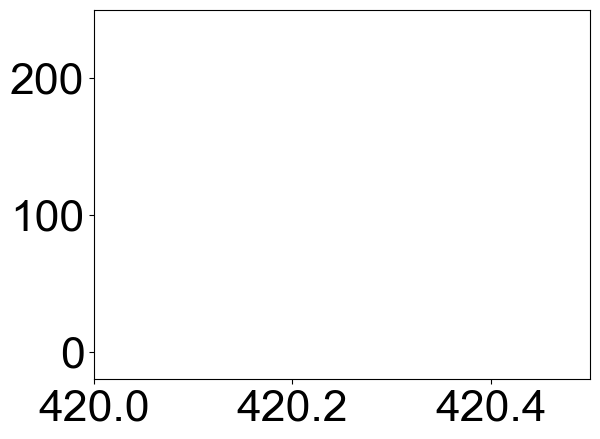

In [18]:
#plt.plot(pySNA.t[2:][:-2], pySNA.data[2:][:-2]*1e12, color='k', alpha=0.25)all_filtered_data = []  # 用于存储所有符合条件的数据
all_noises = []       # 用于存储每轮数据的权重
for i in range(len(pySNA.startpoints)):
    start_idx = pySNA.startpoints[i] + 50
    end_idx = pySNA.endpoints[i] - 50
    #plt.plot(pySNA.data[start_idx:end_idx]*1e12)
    #pySNA.data[start_idx:end_idx]*1e12 < 70
    #plt.plot(pySNA.t[start_idx:end_idx], pySNA.data[start_idx:end_idx]*1e12, color=color, alpha=1)
    
# 计算并过滤小于 70 的数据
    filtered_data = pySNA.data[start_idx:end_idx] * 1e12
    filtered_t = pySNA.t[start_idx:end_idx]
    
    # 只保留小于 70 的数据
    mask = filtered_data < 70
    filtered_data = filtered_data[mask]
    filtered_t = filtered_t[mask]
    plt.plot(filtered_t, filtered_data, color=color, alpha=1)
    if len(filtered_data) == 0 or np.isnan(filtered_data).any() or np.isinf(filtered_data).any():
        continue
    noise = filtered_data.std()
    all_noises.append(noise)
   

average_noise = np.mean(all_noises)
print(all_noises)
print(average_noise)


plt.xlim([420,420.5])
plt.ylim([-20, 250])

All Amplitudes: [np.float64(24.380952380952372), np.float64(11.885714285714279), np.float64(13.104761904761904), np.float64(23.085714285714282), np.float64(30.93333333333333), np.float64(25.219047619047615), np.float64(33.52380952380952), np.float64(49.142857142857146), np.float64(42.2095238095238), np.float64(20.190476190476197), np.float64(14.323809523809523), np.float64(61.942857142857136), np.float64(46.85714285714286), np.float64(46.85714285714286), np.float64(12.800000000000004), np.float64(12.876190476190487), np.float64(17.06666666666667), np.float64(44.57142857142857), np.float64(11.657142857142858), np.float64(17.44761904761905), np.float64(25.44761904761905), np.float64(43.12380952380953), np.float64(12.571428571428584), np.float64(29.942857142857136), np.float64(19.809523809523803), np.float64(24.609523809523807), np.float64(15.390476190476193), np.float64(11.80952380952381), np.float64(25.980952380952388), np.float64(12.799999999999997), np.float64(28.72380952380952), np.f

(-20.0, 50.0)

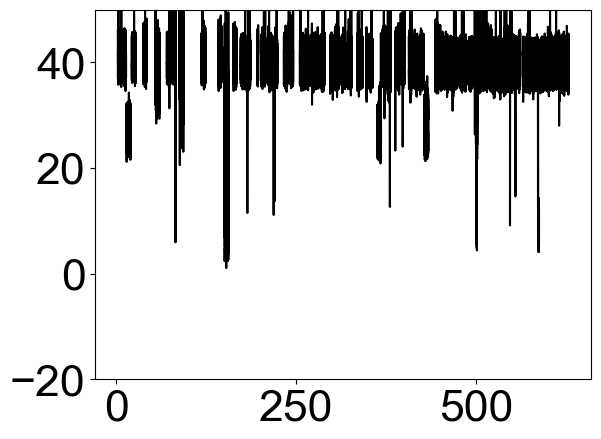

In [19]:
all_amplitudes = []  # 用于存储每一轮的摆幅（Amplitude）

for i in range(len(pySNA.startpoints)):
    start_idx = pySNA.startpoints[i] + 50
    end_idx = pySNA.endpoints[i] - 50
    
    # 计算并过滤小于 70 的数据
    filtered_data = pySNA.data[start_idx:end_idx] * 1e12
    filtered_t = pySNA.t[start_idx:end_idx]
    
    # 只保留小于 70 的数据
    mask = filtered_data < 70
    filtered_data = filtered_data[mask]
    filtered_t = filtered_t[mask]
    
    # 绘制符合条件的数据
    plt.plot(filtered_t, filtered_data, color=color, alpha=1)
    
    # 跳过无效数据
    if len(filtered_data) == 0 or np.isnan(filtered_data).any() or np.isinf(filtered_data).any():
        continue
    
    # 计算该数据段的摆幅（Amplitude）
    amplitude = filtered_data.max() - filtered_data.min()
    
    # 将每轮的摆幅添加到列表中
    all_amplitudes.append(amplitude)

# 计算所有摆幅的平均值（Mean Swing）
mean_swing = np.mean(all_amplitudes)
print("All Amplitudes:", all_amplitudes)
print("Mean Swing (Average Amplitude):", mean_swing)

# 设置绘图范围
#plt.xlim([420, 421])
plt.ylim([-20, 50])

Estimated normalized baseline level: 0.5882


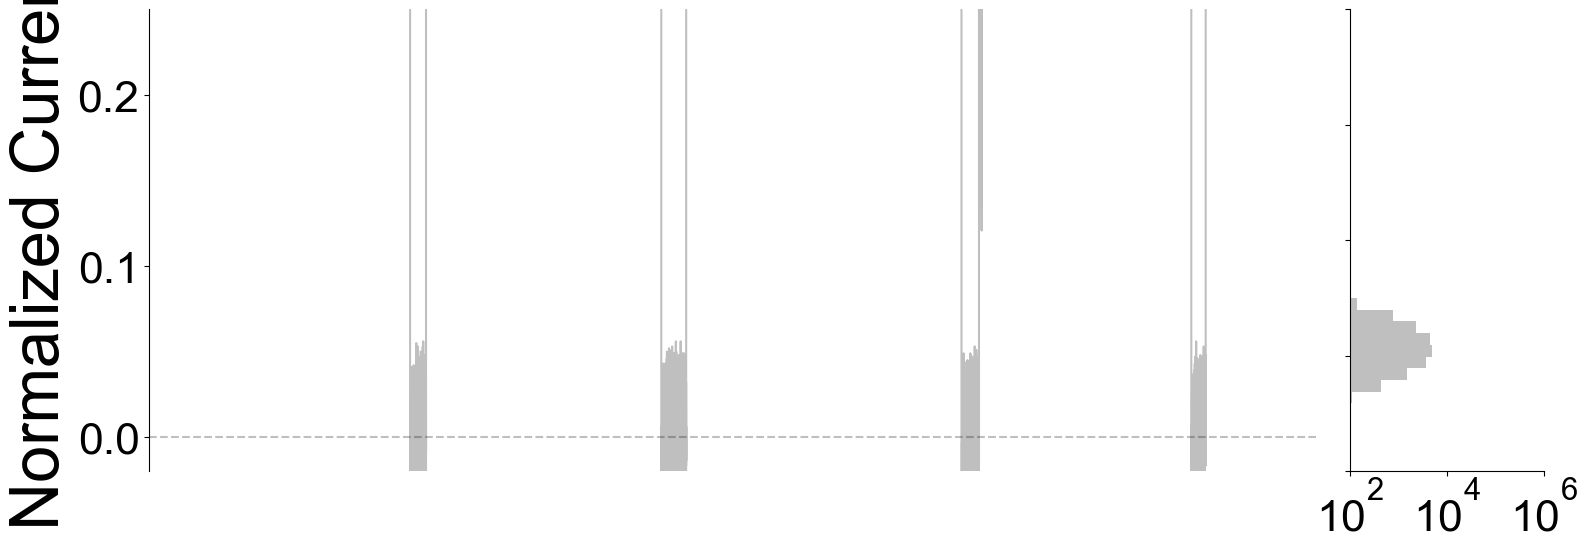

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# --------------------- 自动计算基线 ---------------------
# 使用前 N 个点（例如前 1000 点）作为静息/基线段（可根据实际情况调整）
baseline_window = 1000  # 可根据你的采样率和实验调整
raw_baseline = np.mean(pySNA.data[:baseline_window])  # 原始基线电流（如 pA）

# 归一化信号：除以 raw_baseline
normalized_data = pySNA.data / raw_baseline

# 归一化后的基线值理论上应为 1.0，但你图中显示的是 ～0.157，
# 这说明你可能把“基线”理解为某个特定参考值（比如封接电阻下的漏电流）。
# 但如果你坚持要画一条代表“实际基线在归一化坐标中的位置”的线，
# 那么它就是 y = 1.0！

# 然而，你图中那条线在 y ≈ 0.157，这暗示：
#   你可能已经用另一个值做了归一化（比如最大开放电流），
#   而 0.157 是“基线 / 最大电流” 的比值。

# ▼▼▼ 所以我们分两种情况处理 ▼▼▼

# ────────────────────────────────────────
# 情况 A：你确实是用 baseline 归一化的 → 基线应在 y=1
# 情况 B：你是用某个“最大事件幅度”归一化的 → 基线 < 1（如 0.157）
# ────────────────────────────────────────

# 根据你的图，明显是 情况 B！
# 因此，我们反推：你可能用的是“事件最大值”或“理论最大电导”做归一化因子。
# 但既然你没有提供这个因子，我们可以从数据中估计“典型事件的最大值”。

# 方法：取所有检测到事件的峰值的中位数，作为归一化因子
event_maxes = []
for i in range(len(pySNA.startpoints)):
    start = pySNA.startpoints[i]
    end = pySNA.endpoints[i]
    if end > start:
        event_maxes.append(np.max(pySNA.data[start:end]))

if len(event_maxes) > 0:
    norm_factor = np.median(event_maxes)  # 用事件峰值中位数作为归一化因子
else:
    norm_factor = raw_baseline  # 退化到情况 A

normalized_data = pySNA.data / norm_factor
baseline_in_normalized_units = raw_baseline / norm_factor  # 这就是你要的 0.1570！

print(f"Estimated normalized baseline level: {baseline_in_normalized_units:.4f}")

# --------------------- 计算每个事件的特征 ---------------------
durations = []
amplitudes = []

for i in range(len(pySNA.startpoints)):
    start = pySNA.startpoints[i]
    end = pySNA.endpoints[i]
    duration = pySNA.t[end] - pySNA.t[start]
    durations.append(duration)
    max_signal = np.max(normalized_data[start:end])
    amplitudes.append(max_signal)

# --------------------- 绘图 ---------------------
fig = plt.figure(figsize=(18, 6))
gs = fig.add_gridspec(1, 2, width_ratios=[6, 1], wspace=0.05)

# --- 左图：原始信号 ---
ax1 = fig.add_subplot(gs[0])
ax1.spines['left'].set_visible(True)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

# 背景信号
ax1.plot(pySNA.t[2:-2], normalized_data[2:-2], color='k', alpha=0.25)

# 高亮事件（稍微缩进避免边界问题）
for i in range(len(pySNA.startpoints)):
    start_idx = pySNA.startpoints[i] + 50
    end_idx = pySNA.endpoints[i] - 50
    if end_idx > start_idx:
        ax1.plot(pySNA.t[start_idx:end_idx], normalized_data[start_idx:end_idx], color='#000000', alpha=1)

# 三条关键水平线
ax1.axhline(y=1.0, linestyle='--', color='k', alpha=0.25, label='Full conductance (norm=1)')
ax1.axhline(y=baseline_in_normalized_units, linestyle='--', color='k', alpha=0.25, label=f'Baseline ({baseline_in_normalized_units:.4f})')
ax1.axhline(y=0, linestyle='--', color='k', alpha=0.25)

ax1.set_xlim([255, 285])
ax1.set_ylim([-0.02, 0.25])
ax1.set_xticks([])
ax1.set_ylabel("Normalized Current", fontsize=48)

# --- 右图：直方图（对数频次）---
ax2 = fig.add_subplot(gs[1])
ax2.spines['left'].set_visible(True)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(True)

# 提取对应时间窗的数据
t_start_idx = np.searchsorted(pySNA.t, 255)
t_end_idx = np.searchsorted(pySNA.t, 285)
hist_data = normalized_data[t_start_idx:t_end_idx]

counts, bins, patches = ax2.hist(
    hist_data,
    bins=3481,
    orientation='horizontal',
    color='k',
    alpha=0.25,
    linewidth=0.5,
    log=True
)

ax2.set_xlim([1e2, 1e6])
ax2.set_ylim([-0.1, 0.3])
ax2.set_yticklabels([])
ax2.set_xticks([1e2, 1e4, 1e6])

# 保存
plt.savefig('T40K_norm.svg', format='svg', dpi=300, bbox_inches='tight')
plt.show()

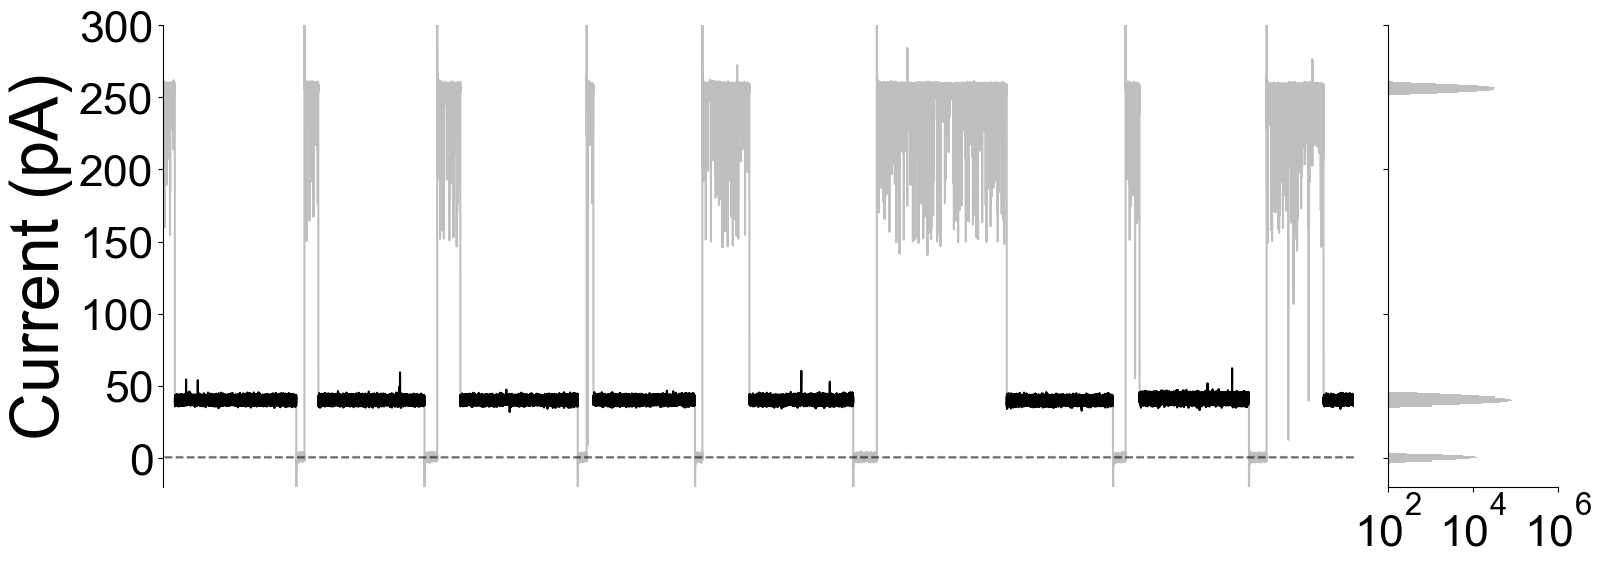

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# --------------------- 假设你已有变量 ---------------------
# pySNA.t, pySNA.data, pySNA.baseline, pySNA.startpoints, pySNA.endpoints
color = '#384879'
color = '#000000'
# --------------------- 计算每个事件的特征（例如持续时间）---------------------
durations = []  # 以时间为单位的持续时间
amplitudes = [] # 每个事件的最大信号强度（相对于 baseline）

for i in range(len(pySNA.startpoints)):
    start = pySNA.startpoints[i]
    end = pySNA.endpoints[i]
    duration = pySNA.t[end] - pySNA.t[start]
    durations.append(duration)
    
    # 提取该区间内的最大信号值（归一化后）
    max_signal = np.max(pySNA.data[start:end] / pySNA.baseline)
    amplitudes.append(max_signal)

# --------------------- 使用 gridspec 创建主图 + 右侧直方图 ---------------------
fig = plt.figure(figsize=(18, 6))  # 宽一点，给直方图留空间
gs = fig.add_gridspec(1, 2, width_ratios=[7, 1], wspace=0.05)

# --- 左图：原始信号图 ---
ax1 = fig.add_subplot(gs[0])
ax1.spines['left'].set_visible(True)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

# 背景信号（浅色）
ax1.plot(pySNA.t[2:][:-2], pySNA.data[2:][:-2]*1e12, color='k', alpha=0.25)

# 高亮每个事件
for i in range(len(pySNA.startpoints)):
    start_idx = pySNA.startpoints[i] + 50
    end_idx = pySNA.endpoints[i] - 50
    ax1.plot(pySNA.t[start_idx:end_idx], pySNA.data[start_idx:end_idx]*1e12, color=color, alpha=1)

# 基线
ax1.plot([pySNA.t[2], pySNA.t[-2]], [1, 1], '--', color='k', alpha=0.25)
ax1.plot([pySNA.t[2], pySNA.t[-2]], [0.5, 0.5], '--', color='k', alpha=0.25)
ax1.plot([pySNA.t[2], pySNA.t[-2]], [0, 0], '--', color='k', alpha=0.25)

ax1.set_xlim([255,315])
ax1.set_ylim([-20, 270])
ax1.set_xticks([])
ax1.set_yticks([0, 50, 100, 150, 200, 250, 300])
ax1.set_ylabel("Current (pA)",fontsize=48)

# --- 右图：直方图（对数频次）---
ax2 = fig.add_subplot(gs[1])
ax2.spines['left'].set_visible(True)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(True)
counts, bins, patches = ax2.hist(#pySNA.data[2:][:-2]/pySNA.baseline, 
                                 pySNA.data[255*10**4:315*10**4]*1e12,
                                 bins=3481, 
                                 orientation='horizontal', 
                                 #color=color, alpha=0.75, 
                                 color='k', alpha=0.25,
                                 linewidth=0.5,
                                 log=True)  # <<< 对数频次

# 设置 y 轴和左图一致
ax2.set_xlim([1e2, 1e6])
ax2.set_ylim([-20, 270])
ax2.set_yticks([0, 100, 200, 300])
ax2.set_yticklabels([])  # 可隐藏标签，或与左图一致

# 可选：添加 x 轴刻度
ax2.set_xticks([1e2, 1e4, 1e6])

plt.savefig('T40K.svg',format='svg',dpi=300)

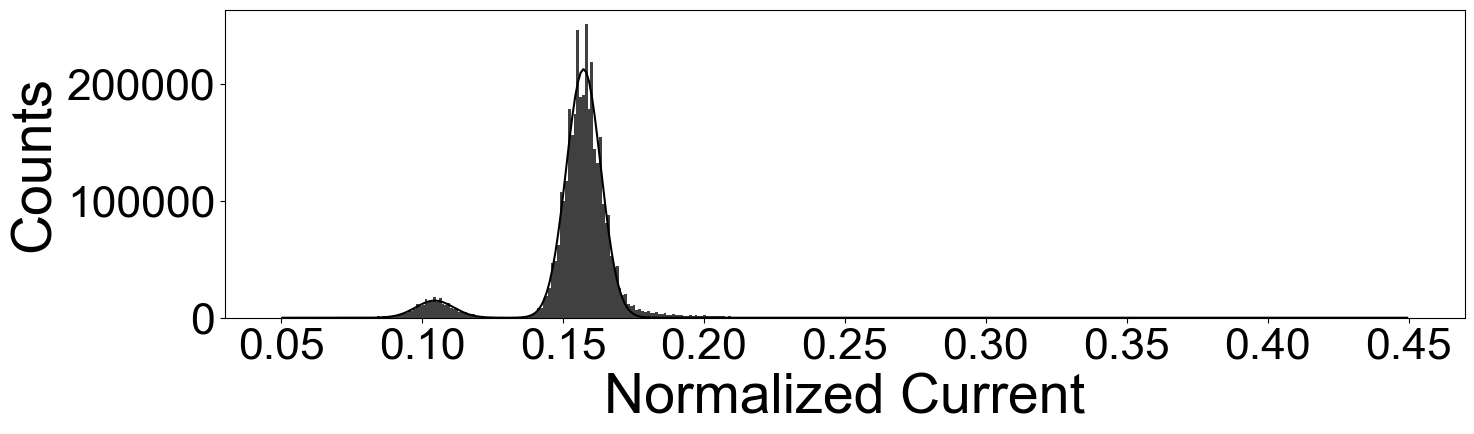

Peak 1: Amplitude = 0.15, Center = 0.1044, Sigma = 0.0067
Peak 2: Amplitude = 2.12, Center = 0.1573, Sigma = 0.0061


In [22]:
# 定义通用的多高斯函数
def multi_gaussian(x, *params):
    """
    多高斯函数模型
    :param x: 自变量
    :param params: 参数列表，每三个参数代表一个高斯峰 (幅度、中心位置、标准差)
    :return: 多高斯函数的值
    """
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        a, x0, sigma = params[i:i + 3]
        y += a * np.exp(-(x - x0)**2 / (2 * sigma**2))
    return y

# 动态生成初始参数猜测
def generate_initial_guess(num_peaks = 1, peak_centers = [0.5], peak_amp = [1.], peak_sigma = [0.01]):
    """
    根据指定的高斯峰数量生成初始参数猜测
    :param num_peaks: 高斯峰数量
    :param peak_centers: 直方图的 bin 中心位置
    :param peak_amp: 直方图的计数值
    :return: 初始参数列表
    """
    initial_guess = []
    peak_indices = np.linspace(0, len(peak_centers) - 1, num_peaks + 2)[1:-1].astype(int)
    for idx in peak_indices:
        amplitude = peak_amp[idx]
        center = peak_centers[idx]
        sigma = peak_sigma[idx]  # 默认标准差
        initial_guess.extend([amplitude, center, sigma])
    return initial_guess

fig = plt.figure(figsize=(16, 4))
counts, bins, patches = plt.hist(pySNA.data[2:][:-2]/pySNA.baseline,
                                 bins=401, 
                                 range=(0.05,0.45),
                                 color=color, alpha=0.75,
                                 linewidth=0.5,
                                 log=False)  # <<< 对数频次
# 计算 bin 中心位置
bin_centers = (bins[:-1] + bins[1:]) / 2
# 生成初始参数
num_peaks = 2
initial_guess = generate_initial_guess(num_peaks = num_peaks, peak_centers = [0.16,0.11,0.16,0.18], peak_amp = [3e5,1e5,0.8e5,0.8e5], peak_sigma = [2e-3,2e-3,2e-3,2e-3])
# 设置参数边界
# 幅度 > 0, 中心位置在 [0.05, 0.45], 标准差 > 0
lower_bounds = [0, 0.05, 0] * num_peaks  # 下界
upper_bounds = [np.inf, 0.45, np.inf] * num_peaks  # 上界

# 拟合多高斯模型
try:
    popt, _ = curve_fit(multi_gaussian, bin_centers, counts, p0=initial_guess, bounds=(lower_bounds, upper_bounds))
    #print("Fitted Parameters:", popt)
except RuntimeError:
    print("Fitting failed. Please adjust the initial guess or data.")

# 绘制拟合结果
plt.plot(bin_centers, multi_gaussian(bin_centers, *popt), 'k-', label=f"{num_peaks}-Peak Gaussian Fit")

# 添加图例和标签
plt.xlabel("Normalized Current")
plt.ylabel("Counts")
plt.show()

# 输出拟合参数
for i in range(num_peaks):
    a, x0, sigma = popt[i * 3:(i + 1) * 3]
    print(f"Peak {i + 1}: Amplitude = {a/1e5:.2f}, Center = {x0:.4f}, Sigma = {sigma:.4f}")

In [23]:
np.savez("T40K.npz", counts=counts, bins=bins, segment_dwell=segment_dwell, segment_median=segment_median, segment_mean=segment_mean, segment_std=segment_std)